In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from PIL import Image, ImageFont, ImageDraw
import cv2
import os
from collections import namedtuple
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import accuracy_score
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CVA1')

# !pwd
if os.path.isfile('NotoColorEmoji.ttf'):
  print("Mounted successfully")


Mounted at /content/drive


# Convert Unicode Emoji to binary image

In [2]:
def emoji_to_image(emoji: str, size: int = 64) -> np.ndarray:

    # For using with cv2 as np.array is returned

    image = Image.new("L", (80,80), (255))

    # Path to color emoji font: Noto_Emoji/NotoColorEmoji.ttf -  Path for not colored: Noto_Emoji/NotoEmoji.ttf
    font = ImageFont.truetype("Noto_Emoji/NotoEmoji.ttf", 64, encoding='unic')

    draw = ImageDraw.Draw(image)
    draw.textbbox(xy=[0,0], text=emoji, font=font)
    draw.text((0, 0), emoji, fill=(0), font=font)
    return np.array(image)

# Task 1
Collect emojis, including those created by Emoji Kitchen, to extend
the reference dataset, convert the emojis to images, and categorize emojis by
emotions, species, etc., into about 20-30 categories. (10 marks)

## Dataset
emoji_categories = {
    'smiling': ['😀', '😃', '😄', '😁', '😆'],
    'affectionate': ['🥰', '😍', '🤩', '😘', '😚'],
    'tongue': ['😋', '😛', '😜', '🤪', '😝'],
    'hands': ['🤗', '🤭', '🫢', '🫣', '🤫'],
    'neutral': ['🙃', '🫠', '🤐', '🤨', '😐'],
    'skeptical': ['😒', '🙄', '😬', '😮‍💨', '🤥'],
    'sleepy': ['😌', '😔', '😪', '😴'],
    'unwell': ['😷', '🤒', '🤕', '🤢', '🤮'],
    'joy': ['😈', '👿', '🤡', '👻', '👽'],
    'doctor': ['🧑‍⚕️', '👨‍⚕️', '👩‍⚕️'],
    'student': ['🧑‍🎓', '👨‍🎓', '👩‍🎓'],
    'farmer': ['🧑‍🌾', '👨‍🌾', '👩‍🌾'],
    'cook':['🧑‍🍳', '👨‍🍳', '👩‍🍳'],
    'fruit': ['🍇', '🍈', '🍉', '🍊', '🍋'],
    'vegetable': ['🍆', '🥔', '🥕', '🌽', '🌶️'],
    'dessert': ['🍦', '🍧', '🍨', '🍩', '🍪', '🎂'],
    'drink': ['🍾', '🍷', '🍺', '🍻', '🥂', '🥃'],
    'award': ['🎖️', '🏆', '🏅', '🥇', '🥈', '🥉'],
    'geography': ['🌍', '🌎', '🌏', '🏔️', '⛰️', '🌋']
  }

In [3]:
# windows + . to get emojis
# Sample of emoji categories
emoji_train = {
    'happy': ['😀', '😃', '😁', '😆','😊','😇','😏','😉'],
    'angry': ['🤬', '👿', '😤'],
    'disgust': ['🤢','🥴','😒','🫤'],
    'fear': ['😨', '😱', '😰', '😖', '😫'],
    'neutral': ['🤐','😶','🫥','😑'],
    'sad': ['😢', '😔', '😟','🥺','😓'],
    'surprise': ['😮', '😲', '😳', '🙀','😦','😧','🤷'],
    'affectionate': ['🥰', '🤩', '😘', '😚','🩷','💓','💞','💋'],
    'tongue': ['😋', '😜', '🤪'],
    'hands': ['🤗', '🤭', '🫢', '🫣', '🤫','🤲','👐','🤚','🙋'],
    'skeptical': ['😒', '🙄', '😬', '😮‍💨', '🤥','🤨','🙎','🙎‍♀️'],
    'sleepy': ['😪', '😴'],
    'unwell': ['😷', '🤒', '🤕', '🤢', '🤮','😵‍💫','🤧'],
    'joy': ['😈', '👿', '🤡', '👻', '👽','🤖','👾','💀'],
    'doctor': ['🧑‍⚕️', '👨‍⚕️', '👩‍⚕️','👨🏼‍⚕️'],
    'student': ['🧑‍🎓', '👨‍🎓', '👩‍🎓','🧑🏾‍🎓','👨‍💼','👩‍💼'],
    'farmer': ['🧑‍🌾', '👨‍🌾', '👩‍🌾','🧑🏻‍🌾','👩🏽‍🌾'],
    'cook': ['🧑‍🍳', '👨‍🍳', '👩‍🍳','🧑🏿‍🍳'],
    'fruit': ['🍇', '🍈', '🍉', '🍊', '🍋','🍌','🍐','🍎','🍓','🍒','🍍'],
    'vegetable': ['🍆', '🥔', '🥕', '🌽', '🌶️','🧅','🥦','🫛'],
    'dessert': ['🍧', '🍨', '🍩', '🍪', '🎂','🍭','🍫','🍬'],
    'drink': ['🍾', '🍷', '🍺', '🥂', '🫙','🧋','🍹'],
    'award': ['🎖️', '🏆', '🏅', '🥇', '🥉'],
    'geography': ['🌍', '🌎', '🏔️', '⛰️', '🌋','🌄','🌅','🏕️','🌐','🗺️'],

}

emoji_test = {

    'happy': ['🙂', '😄'],
    'angry':['😠', '😡'],
    'disgust':['😒', '🤮'],
    'fear':['😣'],
    'neutral': ['🤨', '😐'],
    'sad':['😞', '😭'],
    'surprise':['😯'],
    'affectionate': ['🧡','💛','❤️', '😍'],
    'tongue': ['😛', '😝'],
    'hands': ['✋','🖐️'],
    'skeptical': ['🙎‍♂️'],
    'sleepy': ['💤','🥱'],
    'unwell': ['🥴'],
    'joy': ['☠️'],
    'doctor': ['🧑🏿‍⚕️','👩🏿‍⚕️','👩🏻‍⚕️'],
    'student': ['👩🏼‍💼','🧑🏻‍🎓'],
    'farmer': ['🧑🏽‍🌾','👨🏿‍🌾'],
    'cook':['👩🏻‍🍳','👨🏽‍🍳'],
    'fruit': ['🍏','🥭','🍅'],
    'vegetable': ['🥬'],
    'dessert': ['🧁','🥧','🍦'],
    'drink': ['🍻','🥤', '🧃'],
    'award': ['🥈'],
    'geography': ['🏞️','⛺','🌏'],

}

print("Number of classes: " + str(len(emoji_train)))
print("Estimated Probability of guessing at random:", 1/len(emoji_train)*100, "%")
print(len(emoji_train) == len(emoji_test))

Number of classes: 24
Estimated Probability of guessing at random: 4.166666666666666 %
True


In [4]:
# Transforming the Unicode emojis into Images
def transform(data):

  for k, v in data.items():

    for i in range(len(v)):
      v[i] = emoji_to_image(v[i])


In [5]:
transform(emoji_train)
transform(emoji_test)

In [6]:
# Add training data from Emoji Kitchen
src = 'SmallDataset/train'
folders = os.listdir(src)

for folder in folders:
    folder_path = os.path.join(src, folder)

    if os.path.isdir(folder_path):

        image_files = os.listdir(folder_path)
        for image_file in image_files:
            # Add gray images
            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
            img = cv2.resize(img, (80, 80), interpolation=cv2.INTER_AREA)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            emoji_train[folder].append(gray)



In [7]:
def show(image):
  image = image.reshape((80,80))
  cv2_imshow(image)

## Understanding the Data

### TSNE

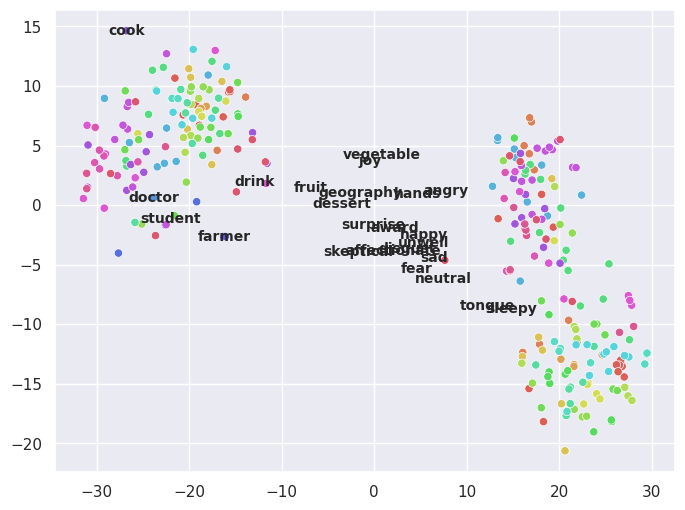

In [8]:
## visualize images in feature space using t-SNE with IDs and Labels for image

sns.set(rc={'figure.figsize':(8,6)})
palette = sns.color_palette("hls", len(emoji_train))

features = []
labels = []
for k in emoji_train.keys():
  for v in emoji_train[k]:
    features.append(v.flatten())
    labels.append(k)

features = np.array(features)
labels = np.array(labels)
# labels = np.array([k for k in emoji_train.keys()])

tsne = TSNE()
X_embedded = tsne.fit_transform(features)
plot = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels, legend=False, palette=palette)

# Add centroid label to each class

# Calculate class centroids
class_centroids = {}
for label in np.unique(labels):
  i = np.where(labels == label)[0]
  class_centroid = np.mean(X_embedded[i], axis=0)
  class_centroids[label] = class_centroid

# Add labels for each class centroid
for label, centroid in class_centroids.items():
  plot.text(centroid[0], centroid[1], label, ha='center', va='center', fontsize=10, fontweight='bold')

plt.show()

# Task 2
Design methods to extract features from emojis and consider whether there are better feature extraction methods. (10 marks)

## Preprocess Emojis

In [9]:
# Circle LBP

def circle_LBP (img: np.array, r: int, p:int):
    """ circle_LBP algorithm

    Params:
        img:
            An image with size of H x W.
        r:
            The radius of circle, e.g., 3
        p:
            The number of sampling points, e.g., 8
    """

    # img = img.reshape((64,64))
    h, w = img.shape
    dst = np.zeros((h, w), dtype=img.dtype)

    for i in range(r, h-r):
      for j in range(r, w-r):
        LBP_str = []
        for k in range(p):

            # STEP 1:
            rx = i + r*np.cos(2*np.pi*k/p)
            ry = j - r*np.sin(2*np.pi*k/p)

            # STEP 2:
            x0 = int(np.floor(rx))
            x1 = int(np.ceil(rx))
            y0 = int(np.floor(ry))
            y1 = int(np.ceil(ry))

            # STEP 3:
            f00 = img[x0, y0]
            f01 = img[x0, y1]
            f10 = img[x1, y0]
            f11 = img[x1, y1]
            w1 = x1 - rx
            w2 = rx - x0
            w3 = y1 - ry
            w4 = ry - y0
            fxy = w3*(w1*f00 + w2*f10) + w4*(w1*f01+w2*f11)

            # STEP 4:
            if fxy >= img[i, j]:
                LBP_str.append(1)
            else:
                LBP_str.append(0)
        LBP_str = ''.join(str(id) for id in LBP_str)
        dst[i, j] = int(LBP_str, 2)

    return dst


In [11]:
# sobel
def sobel(img):
  sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
  sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
  sobel = np.absolute(sobel_x) + np.absolute(sobel_y)
  sobel = (255-sobel)
  return sobel

# Laplacian
def laplacian(img):
  laplacian = cv2.Laplacian(img, cv2.CV_64F).astype(np.uint8)
  laplacian = (255-laplacian)
  return laplacian

# hog
kernel = np.ones((3, 3), np.uint8)
def ihog(img):
  _, hogim = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1, multichannel=False)
  hogim = (255-hogim)
  return hogim

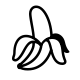

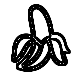

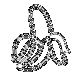

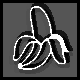

<ipython-input-12-6bc02320e78f>:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  _, hogim = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1, multichannel=False)


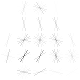

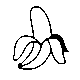

In [13]:
# 🙂
t = emoji_to_image('🍌')
show(t)

show(sobel(t))

show(laplacian(t))

show(circle_LBP(t, r=3, p=8))

show(ihog(t))



## Preprocess Function

In [14]:
def preprocess(data):

  x = []

  for img in data:

        # Extract different features

        # Sobel filter
        sobelim = sobel(img).flatten()
        img_array = sobelim

        # Laplacian
        laplacianim = laplacian(img).flatten()
        img_array = np.hstack((img_array, laplacianim))

        # LBP
        LBP = circle_LBP(img, r=3, p=8).flatten()
        img_array = np.hstack((img_array, LBP))

        # Hog
        hogim = ihog(img).flatten()
        img_array = np.hstack((img_array, hogim))

        x.append(img_array)

  return np.array(x)

## Extract Features

### Function for separating x, y labels

In [15]:
def features(data):
  # flatten images for training model
  # Add preprocessing here

  x = []
  y = []

  for k, v in data.items():

    for i in v:

      x.append(i)
      y.append(k)

  x = np.array(x)
  y = np.array(y)

  return x, y

x_train, y_train = features(emoji_train)
x_train = preprocess(x_train)

<ipython-input-12-6bc02320e78f>:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  _, hogim = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1, multichannel=False)


# Task 3
Train a classifier for emoji classification. Consider how to validate the classifier to improve the test performance further. (20 marks)


## Model Creation and Training

### Define the model

In [16]:
# Define the classifier and cross-validation settings
model = SVC()

### Grid Search with Cross-Validation

In [17]:
# Grid Search and CrossValidation

# Define the parameter grid for hyperparameter search
param_grid = {
  'C': [0.01, 0.1, 1, 10],  # Regularization parameter
  'kernel': ['linear', 'rbf'],  # Kernel options
  'gamma': [0.1, 0.01, 0.001],
}

kfold = KFold(n_splits=5, shuffle=True)  # 5-fold cross-validation with shuffling

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best model
model = grid_search.best_estimator_

In [70]:
print(grid_search.cv_results_['mean_test_score'])
print(model.get_params())
print(model)

[0.4922619  0.0437996  0.4922619  0.0437996  0.4922619  0.0437996
 0.4922619  0.0437996  0.4922619  0.0437996  0.4922619  0.0437996
 0.4922619  0.10962302 0.4922619  0.10962302 0.4922619  0.10962302
 0.4922619  0.10962302 0.4922619  0.10962302 0.4922619  0.10962302]
{'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
SVC(C=0.01, gamma=0.1, kernel='linear')


# Task 4
Test the classifier using emojis created by Emoji Kitchen that are unseen in the training and validation processes. (10 marks)

## Get the Test Data

In [19]:
# Get features from the dataset
x_test, y_test = features(emoji_test)
x_test = preprocess(x_test)

<ipython-input-12-6bc02320e78f>:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  _, hogim = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1, multichannel=False)


## Prediction and Accuracy

In [20]:
# predict on the test set
y_pred = model.predict(x_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 60.42%


## Log of results with different approaches

* SVM with hog and LBP: 55.26%
* Accuracy with small training data, with hog and LBP: 47.92%
* Accuracy imitating a CNN: 60.42%

### Error Checking

In [55]:
# Error check
error = [(true, pred) for true, pred in zip(y_test, y_pred) if pred != true]
print(error)

[('angry', 'sad'), ('angry', 'sad'), ('disgust', 'skeptical'), ('disgust', 'unwell'), ('fear', 'skeptical'), ('neutral', 'skeptical'), ('hands', 'geography'), ('hands', 'dessert'), ('sleepy', 'vegetable'), ('sleepy', 'affectionate'), ('unwell', 'disgust'), ('joy', 'happy'), ('fruit', 'hands'), ('vegetable', 'geography'), ('dessert', 'drink'), ('dessert', 'fruit'), ('drink', 'affectionate'), ('drink', 'fruit'), ('geography', 'joy')]


# Task 5
Test the model using human face emotions datasets, such as the face expression dataset from Kaggle, or sketches of facial emotions that you convert from digital portrait images. Consider how to improve the classifier's performance on the new kind of data. (10 marks)

## Read Human Faces Emotion dataset

In [56]:
# Read the data

src = 'FaceExpression/validation'
folders = os.listdir(src)

x_test = []
y_test = []



for folder in folders:
    folder_path = os.path.join(src, folder)
    if os.path.isdir(folder_path):
        image_files = os.listdir(folder_path)
        c = 0
        for image_file in image_files:

            if c == 100:  # To avoid dealing with long time
              break

            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
            img = cv2.resize(img, (80, 80), interpolation=cv2.INTER_AREA)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            x_test.append(gray)
            y_test.append(folder)
            c += 1

x_test = np.array(x_test)
y_test = np.array(y_test)

print("Number of samples for face dataset:", len(x_test))

x_test = preprocess(x_test)


Number of samples for face dataset: 679


<ipython-input-38-6bc02320e78f>:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  _, hogim = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1, multichannel=False)


In [57]:
x_test.shape

(679, 32000)

In [58]:
# predict on the human faces dataset set.
y_pred = model.predict(x_test)

# calculate accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 0.00%


Counter({('happy', 'hands'): 91, ('surprise', 'hands'): 90, ('angry', 'hands'): 90, ('fear', 'hands'): 89, ('sad', 'hands'): 88, ('neutral', 'hands'): 87, ('disgust', 'hands'): 76, ('neutral', 'award'): 11, ('angry', 'award'): 10, ('sad', 'award'): 10, ('fear', 'award'): 10, ('surprise', 'award'): 9, ('happy', 'award'): 6, ('disgust', 'award'): 3, ('happy', 'affectionate'): 2, ('surprise', 'sad'): 1, ('happy', 'vegetable'): 1, ('neutral', 'happy'): 1, ('neutral', 'sad'): 1, ('sad', 'vegetable'): 1, ('sad', 'dessert'): 1, ('fear', 'affectionate'): 1})


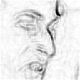

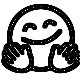

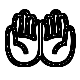

In [66]:
from collections import Counter
# Error check
error = [(true, pred) for true, pred in zip(y_test, y_pred) if pred != true]
c = Counter(error)
print(c)

img = cv2.imread(image_path, cv2.IMREAD_COLOR)[..., ::-1]
img = cv2.resize(img, (80, 80), interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show(sobel(gray))

show(sobel(emoji_to_image('🤗')))
show(sobel(emoji_to_image('🤲')))

Possible Improvements:
For improvement: Sift and using other dataset for training

